In [ ]:
import pandas as pd
import numpy as np
from typing import Optional, Union, Tuple, Iterable, Callable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os
from typing import List, Tuple, Optional, Dict
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from datetime import datetime, timezone, timedelta

In [ ]:
IPERF_COLUMN = "bits_per_second"
IRTT_COLUMN = "rtt_ms"
TIME_COLUMN = "timestamp_iso"

# ==== STEP 1: Load and Format Trace from Two Files ====
def load_data(hour, minute, day):
    iperf_csv = f"./data/2023-09-{day}/iperf3-2m-2023-09-{day}-{hour:0{2}d}-{minute:0{2}d}-00.csv"
    irtt_csv = f"./data/2023-09-{day}/irtt-10ms-2m-2023-09-{day}-{hour:0{2}d}-{minute:0{2}d}-00.csv"
    # Load both files
    iperf_df = pd.read_csv(iperf_csv)
    irtt_df = pd.read_csv(irtt_csv)

    # Parse timestamp (ISO strings with timezone) as tz-aware UTC datetimes
    iperf_df[TIME_COLUMN] = pd.to_datetime(iperf_df[TIME_COLUMN], format="ISO8601", utc=True)

    irtt_df[TIME_COLUMN] = pd.to_datetime(irtt_df[TIME_COLUMN], format="ISO8601", utc=True)
    irtt_df[TIME_COLUMN].isin(iperf_df[TIME_COLUMN])
    return iperf_df, irtt_df

In [55]:
def round_dt(dt_object):
    """
    Rounds a datetime object to the nearest second.
    """
    # Calculate the number of microseconds
    microseconds = dt_object.microsecond

    # If microseconds are 500,000 or more, round up to the next second
    if microseconds >= 500000:
        dt_object += timedelta(seconds=1)

    # Remove the microsecond component
    rounded_dt = dt_object.replace(microsecond=0)
    return rounded_dt

def plot_figures(iperf_df, irtt_df):
    start_time = iperf_df[TIME_COLUMN].min()
    end_time = iperf_df[TIME_COLUMN].max()

    date_form = mdates.DateFormatter("%H:%M:%S")

    # Plot raw samples (convert bps -> Mbps)
    fig, ax = plt.subplots(2, figsize=(20,5))
    ax[0].scatter(iperf_df[TIME_COLUMN], iperf_df[IPERF_COLUMN] / 1e6, s=6, alpha=0.4)
    # ax[0].plot(iperf_df[TIME_COLUMN], iperf_df[IPERF_COLUMN].rolling(window=20).mean() / 1e6, alpha=0.7, c='black')
    ax[0].plot(iperf_df[TIME_COLUMN], iperf_df[IPERF_COLUMN].rolling(window=20).mean() / 1e6, alpha=0.7, c='black')
    ax[0].set_xlabel('Time (UTC)')
    ax[0].set_ylabel('Throughput (Mbps)')
    ax[0].set_title(f'Throughput (raw samples) from {round_dt(start_time).strftime("%Y-%m-%d %H:%M:%S")} to {round_dt(end_time).strftime("%Y-%m-%d %H:%M:%S")}')
    ax[0].grid(True)
    # ax[0].tick_params(axis='x', labelrotation=45) 
    ax[0].set_xticks(pd.date_range(round_dt(start_time), round_dt(end_time), freq="15s", unit="s") - pd.DateOffset(seconds=3))
    for i in pd.date_range(round_dt(start_time), round_dt(end_time), freq="15s", unit="s") - pd.DateOffset(seconds=2):
        ax[0].axvline(i, ls=":", lw=0.7, c='red')
    ax[0].xaxis.set_major_formatter(date_form)

    ax[1].scatter(irtt_df[TIME_COLUMN], irtt_df[IRTT_COLUMN], s=6, alpha=0.1)
    # ax[1].plot(irtt_df[TIME_COLUMN], irtt_df[IRTT_COLUMN].rolling(window=10).mean(), alpha=0.7, c='black')
    ax[1].plot(irtt_df[TIME_COLUMN][::10], irtt_df[IRTT_COLUMN].rolling(window=10).mean()[::10], alpha=0.7, c='black')
    ax[1].set_xlabel('Time (UTC)')
    ax[1].set_ylabel('Latency (ms)')
    ax[1].set_title(f'Latency (raw samples) from {round_dt(start_time).strftime("%Y-%m-%d %H:%M:%S")} to {round_dt(end_time).strftime("%Y-%m-%d %H:%M:%S")}')
    ax[1].grid(True)
    # ax[1].tick_params(axis='x', labelrotation=45) 
    ax[1].set_xticks(pd.date_range(round_dt(start_time), round_dt(end_time), freq="15s", unit="s") - pd.DateOffset(seconds=3))
    for i in pd.date_range(round_dt(start_time), round_dt(end_time), freq="15s", unit="s") - pd.DateOffset(seconds=2):
        ax[1].axvline(i, ls=":", lw=0.7, c='red')
    ax[1].xaxis.set_major_formatter(date_form)
    plt.tight_layout()
    plt.show()

(1200, 2)
(11550, 2)


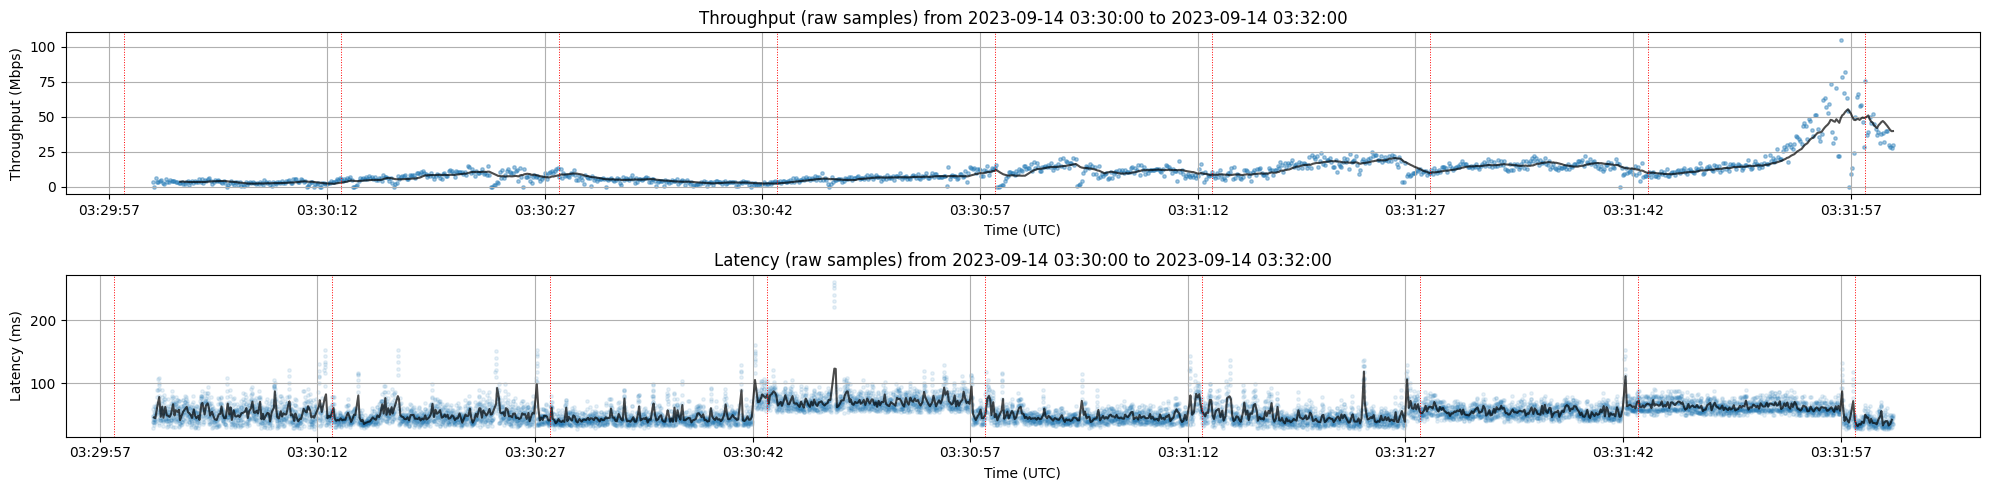

In [56]:
hour = 3
minute = 30
day = 14
plot_figures(*load_data(hour, minute, day))

(1200, 2)
(11635, 2)


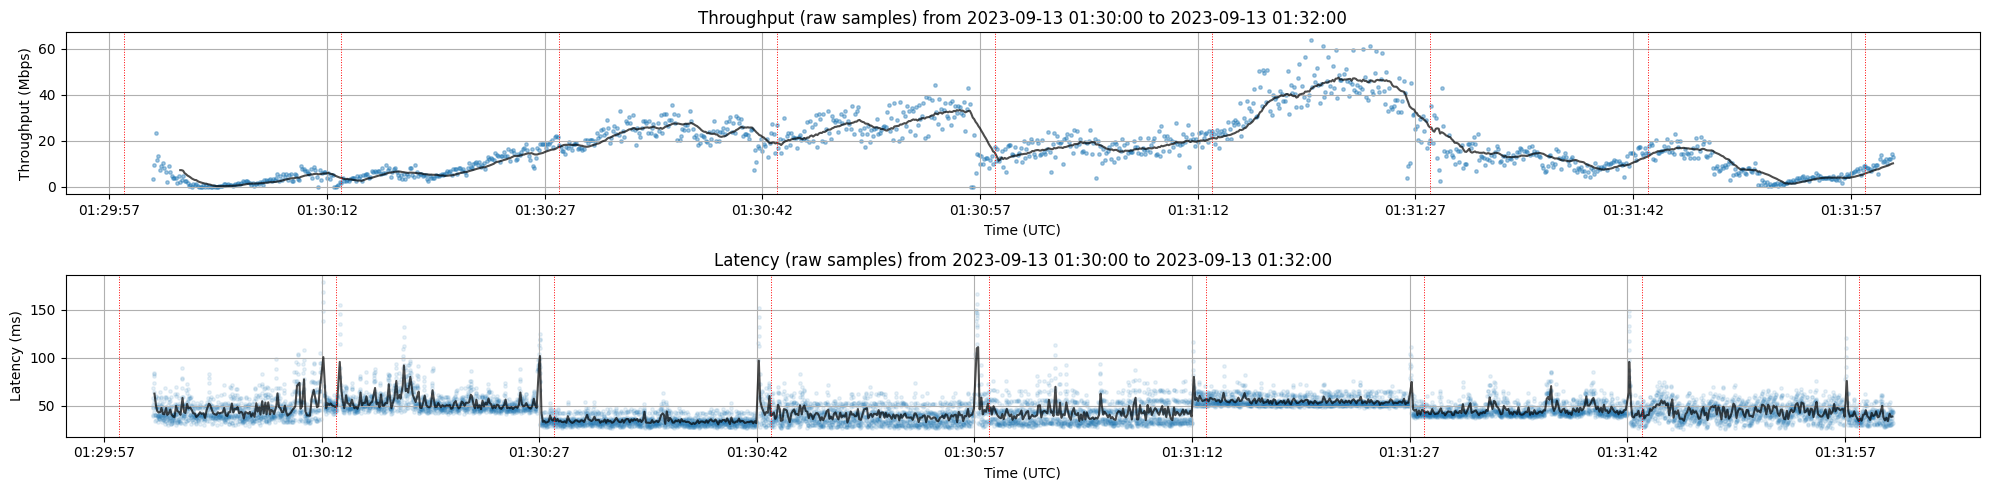

In [61]:
hour = np.random.randint(0,24)
minute = np.random.randint(0,6) * 10
day = np.random.randint(13,18)
plot_figures(*load_data(hour, minute, day))

In [27]:
class TimeSeriesPairDataset(Dataset):
    """
    Custom PyTorch Dataset for loading paired irtt and iperf3 CSV time series and producing
    samples for a 2-channel multivariate forecasting model (e.g., PatchTST).

    Features:
      - Reads two-minute windows from paired CSVs:
          "2023-09-{day}/irtt-10ms-2m-2023-09-{day:02d}-{hour:02d}-{minute:02d}-00.csv"
          "2023-09-{day}/iperf3-2m-2023-09-{day:02d}-{hour:02d}-{minute:02d}-00.csv"
      - Rounds timestamps:
          - irtt: nearest 10ms, then resamples to 100ms
          - iperf3: nearest 100ms
      - Smooths both channels with rolling window averages (default window=20 samples)
      - iperf3 bits_per_second -> Mb/s (divide by 1e6 after smoothing)
      - Builds context/horizon splits at second offsets:
          minute 0: 13, 28, 43, 58
          minute 1: 73, 88, 103, 118
        Context ends at these splits; horizon starts exactly at these splits.
      - context_len and pred_len are in 100ms steps (e.g., 280 -> 28.0 seconds).
      - Returns tensors shape:
          x: (2, context_len)
          y: (2, pred_len)

    Parameters:
      data_dir: root directory where day folders live (e.g., ".../data")
      context_len: int, number of 100ms steps in the context
      pred_len: int, number of 100ms steps in the prediction horizon
      days: iterable of day ints to include (default [13,14,15,16,17])
      hours: iterable of hour ints to include (default range(0,24))
      minutes: iterable of minute ints to include (default [0,10,20,30,40,50])
      smoothing_window: int, rolling window (in samples) for noise reduction (default 20)
      drop_incomplete: bool, if True, drop samples where either channel has NaNs
                       in context or horizon after processing. If False, will
                       time-interpolate + ffill/bfill to fill gaps.
      cache_pairs: bool, cache the processed 2-minute pair data for reuse within the Dataset
                   (helps performance if many samples per pair)
      verbose: bool, print info about skipped/missing files and summary

    Notes:
      - All timestamps are treated as UTC. The standardized 2-minute index is anchored at exactly
        YYYY-MM-DD HH:MM:00+00:00 to HH:MM+2:00+00:00 at 100ms frequency (1200 steps).
      - If a CSV's actual timestamps are off slightly, rounding and resampling align them.
    """

    MONTH_STR = "2023-09"
    FILE_MINUTES_PER_PAIR = 2  # fixed to 2 minutes per pair
    STEP_MS = 100              # base sampling interval for model is 100ms
    STEPS_PER_SECOND = 10      # 100ms steps in a second
    TOTAL_STEPS = FILE_MINUTES_PER_PAIR * 60 * STEPS_PER_SECOND  # 1200 steps over 2 minutes

    # Split seconds within the 2-minute window where context ends and horizon begins.
    SPLIT_SECONDS = [13, 28, 43, 58, 73, 88, 103, 118]

    def __init__(
        self,
        data_dir: str,
        context_len: int,
        pred_len: int,
        days: Optional[List[int]] = None,
        hours: Optional[List[int]] = None,
        minutes: Optional[List[int]] = None,
        smoothing_window: int = 20,
        drop_incomplete: bool = False,
        cache_pairs: bool = True,
        verbose: bool = False,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.context_len = int(context_len)
        self.pred_len = int(pred_len)
        self.smoothing_window = int(smoothing_window)
        self.drop_incomplete = drop_incomplete
        self.cache_pairs = cache_pairs
        self.verbose = verbose

        self.days = days if days is not None else [13, 14, 15, 16, 17]
        self.hours = hours if hours is not None else list(range(0, 24))
        self.minutes = minutes if minutes is not None else [0, 10, 20, 30, 40, 50]

        # Precompute sample index metadata: (pair_key, start_idx, split_idx, end_idx)
        # where end_idx = split_idx, start_idx = split_idx - context_len, horizon_end_idx = split_idx + pred_len
        self.samples: List[Tuple[str, int, int, int]] = []
        self.pair_index: Dict[str, Dict] = {}  # pair_key -> metadata (paths, etc.)
        self._pair_cache: Dict[str, np.ndarray] = {}  # optional cache of merged (T, 2) float32 arrays

        self._build_index()

        if self.verbose:
            print(f"Built dataset with {len(self.samples)} samples across {len(self.pair_index)} file pairs.")

    def _build_index(self):
        for day in self.days:
            day_folder = os.path.join(self.data_dir, f"{self.MONTH_STR}-{day:02d}")
            for hour in self.hours:
                for minute in self.minutes:
                    irtt_path = os.path.join(
                        day_folder,
                        f"irtt-10ms-2m-{self.MONTH_STR}-{day:02d}-{hour:02d}-{minute:02d}-00.csv",
                    )
                    iperf_path = os.path.join(
                        day_folder,
                        f"iperf3-2m-{self.MONTH_STR}-{day:02d}-{hour:02d}-{minute:02d}-00.csv",
                    )

                    if not (os.path.isfile(irtt_path) and os.path.isfile(iperf_path)):
                        if self.verbose:
                            print(f"Skipping missing pair: day={day}, hour={hour}, minute={minute}")
                        continue

                    # Define the standardized two-minute window start in UTC
                    start_dt = datetime(2023, 9, day, hour, minute, 0, tzinfo=timezone.utc)

                    pair_key = f"{day:02d}-{hour:02d}-{minute:02d}"
                    self.pair_index[pair_key] = {
                        "irtt_path": irtt_path,
                        "iperf_path": iperf_path,
                        "start_dt": start_dt,
                    }

                    # For each split second, compute valid sample indices
                    for split_sec in self.SPLIT_SECONDS:
                        split_idx = split_sec * self.STEPS_PER_SECOND  # 100ms ticks
                        start_idx = split_idx - self.context_len
                        horizon_end_idx = split_idx + self.pred_len

                        # Valid if context starts within [0, TOTAL_STEPS] and horizon ends <= TOTAL_STEPS
                        if start_idx < 0 or horizon_end_idx > self.TOTAL_STEPS:
                            continue

                        # Record sample: (pair_key, start_idx, split_idx, horizon_end_idx)
                        self.samples.append((pair_key, start_idx, split_idx, horizon_end_idx))

    def __len__(self) -> int:
        return len(self.samples)

    def _read_and_process_pair(self, pair_key: str) -> np.ndarray:
        """
        Load irtt and iperf3 CSVs for a given key, align to a standardized 100ms grid over
        exactly 2 minutes (1200 steps), smooth, and produce a (T, 2) float32 array:
          col0: irtt rtt_ms (smoothed)
          col1: iperf Mbps (smoothed, converted from bits/s)
        """
        # Return from cache if available
        if self.cache_pairs and pair_key in self._pair_cache:
            return self._pair_cache[pair_key]

        meta = self.pair_index[pair_key]
        irtt_path = meta["irtt_path"]
        iperf_path = meta["iperf_path"]
        start_dt: datetime = meta["start_dt"]
        # Standardized 100ms index for 2 minutes
        index = pd.date_range(start=start_dt, periods=self.TOTAL_STEPS, freq=f"{self.STEP_MS}ms", tz="UTC")

        # Load irtt
        irtt_df = pd.read_csv(irtt_path)
        irtt_df["ts"] = pd.to_datetime(irtt_df["timestamp_iso"], utc=True, format="ISO8601").dt.round("10ms")
        # Set index and resample to 100ms (mean)
        irtt_series = (
            irtt_df.set_index("ts")["rtt_ms"]
            .sort_index()
            .resample(f"{self.STEP_MS}ms").mean()
        )

        # Load iperf3
        iperf_df = pd.read_csv(iperf_path)
        iperf_df["ts"] = pd.to_datetime(iperf_df["timestamp_iso"], utc=True, format="ISO8601").dt.round("100ms")
        iperf_series = (
            iperf_df.set_index("ts")["bits_per_second"]
            .sort_index()
            .resample(f"{self.STEP_MS}ms").mean()
        )

        # Reindex to standardized grid (align to exact minute boundary)
        # Combine into one DataFrame on the standardized index
        df = pd.DataFrame(index=index)
        df["irtt_ms"] = irtt_series.reindex(index)
        df["bits_per_second"] = iperf_series.reindex(index)

        # Fill small gaps by time interpolation, then ffill/bfill to ensure full coverage
        df["irtt_ms"] = df["irtt_ms"].interpolate(method="time", limit_direction="both")
        df["bits_per_second"] = df["bits_per_second"].interpolate(method="time", limit_direction="both")
        df["irtt_ms"] = df["irtt_ms"].ffill().bfill()
        df["bits_per_second"] = df["bits_per_second"].ffill().bfill()

        # Smooth with rolling mean; min_periods=1 to avoid dropping early points
        df["irtt_ms"] = df["irtt_ms"].rolling(window=self.smoothing_window, min_periods=1).mean()
        df["mbps"] = (df["bits_per_second"].rolling(window=self.smoothing_window, min_periods=1).mean()) / 1e6

        # Prepare the 2-channel array (T, 2)
        arr = np.vstack([df["irtt_ms"].to_numpy(), df["mbps"].to_numpy()]).T.astype(np.float32)

        if self.cache_pairs:
            self._pair_cache[pair_key] = arr
        return arr

    def __getitem__(self, idx: int):
        pair_key, start_idx, split_idx, horizon_end_idx = self.samples[idx]
        arr = self._read_and_process_pair(pair_key)  # (T, 2)
        # Slice context [start_idx, split_idx) and horizon [split_idx, horizon_end_idx)
        context = arr[start_idx:split_idx]     # shape (context_len, 2)
        horizon = arr[split_idx:horizon_end_idx]  # shape (pred_len, 2)

        # Optionally drop samples with NaNs
        if self.drop_incomplete:
            if np.isnan(context).any() or np.isnan(horizon).any():
                raise RuntimeError(f"Encountered NaNs in sample {idx} for pair {pair_key}")

        # Return as channels-first tensors: (2, seq_len)
        x = torch.from_numpy(context.copy())  # (2, context_len)
        y = torch.from_numpy(horizon.copy())  # (2, pred_len)

        # You can also return metadata if useful
        meta = {
            "pair_key": pair_key,
            "start_dt": self.pair_index[pair_key]["start_dt"].isoformat(),
            "context_start_offset_s": start_idx / self.STEPS_PER_SECOND,
            "split_offset_s": split_idx / self.STEPS_PER_SECOND,
            "horizon_end_offset_s": horizon_end_idx / self.STEPS_PER_SECOND,
        }
        return x, y, meta

In [ ]:
# Instantiate the dataset
data_dir = "data" # change to wherever your datasets is located
dataset = TimeSeriesPairDataset(
    data_dir=data_dir,
    context_len=280,     # 28.0 seconds of context (280 * 100ms)
    pred_len=140,        # 14.0 seconds horizon (140 * 100ms)
    smoothing_window=10, # ~1s rolling mean at 100ms sampling
    verbose=True
)

print(f"Total valid contexts: {len(dataset)}")

# Fetch a sample
x, y, meta = dataset[0]
print("x shape (channels, context_len):", x.shape)
print("y shape (channels, pred_len):", y.shape)
print("meta:", meta)

# Use with DataLoader
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Skipping missing pair: day=13, hour=0, minute=0
Skipping missing pair: day=13, hour=0, minute=10
Skipping missing pair: day=13, hour=0, minute=20
Skipping missing pair: day=13, hour=0, minute=30
Built dataset with 4296 samples across 716 file pairs.
Total valid contexts: 4296
x shape (channels, context_len): torch.Size([280, 2])
y shape (channels, pred_len): torch.Size([140, 2])
meta: {'pair_key': '13-00-40', 'start_dt': '2023-09-13T00:40:00+00:00', 'context_start_offset_s': 0.0, 'split_offset_s': 28.0, 'horizon_end_offset_s': 42.0}


In [ ]:
from transformers import PatchTSTConfig, PatchTSTForPrediction
import torch.optim as optim
device = 'cuda:0' # change to "cpu" if you're using your laptop
configuration = PatchTSTConfig(context_length=(12+15+1)*10, 
                               patch_length=10, 
                               num_input_channels=2, 
                               prediction_length=14*10, 
                               channel_attention=True)

# Randomly initializing a model (with random weights) from the configuration
model = PatchTSTForPrediction(configuration).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accessing the model configuration
configuration = model.config

In [43]:
losses = []
loader = DataLoader(dataset, batch_size=32, shuffle=True)
epochs = 10
for epoch in range(epochs):
    for i, batch in enumerate(loader):
        x_batch, y_batch, meta_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(past_values=x_batch, future_values=y_batch)
        loss = outputs.loss
        print(f"{epoch}.{i}: loss: {loss.item()}")
        losses.append(loss.item())
        optimizer.zero_grad() # Clear gradients from previous epoch
        loss.backward()       # Compute gradients
        optimizer.step()      # Update model parameters

0.0: loss: 4258.8154296875
0.1: loss: 298.3667297363281
0.2: loss: 625.2811279296875
0.3: loss: 176.4764862060547
0.4: loss: 1755.975341796875
0.5: loss: 742.9354858398438
0.6: loss: 1928.1009521484375
0.7: loss: 1782.29833984375
0.8: loss: 180.85708618164062
0.9: loss: 236.36749267578125
0.10: loss: 176.36697387695312
0.11: loss: 1581.2423095703125
0.12: loss: 713.5438842773438
0.13: loss: 177.78736877441406
0.14: loss: 980.9613647460938
0.15: loss: 174.1267547607422
0.16: loss: 885.925537109375
0.17: loss: 216.03753662109375
0.18: loss: 512.1512451171875
0.19: loss: 2400.708740234375
0.20: loss: 326.22198486328125
0.21: loss: 184.99356079101562
0.22: loss: 571.2879028320312
0.23: loss: 618.5870361328125
0.24: loss: 2048.08740234375
0.25: loss: 170.4843292236328
0.26: loss: 324.4927062988281
0.27: loss: 159.52491760253906
0.28: loss: 466.21551513671875
0.29: loss: 287.10040283203125
0.30: loss: 851.5879516601562
0.31: loss: 831.70361328125
0.32: loss: 243.04104614257812
0.33: loss: 25

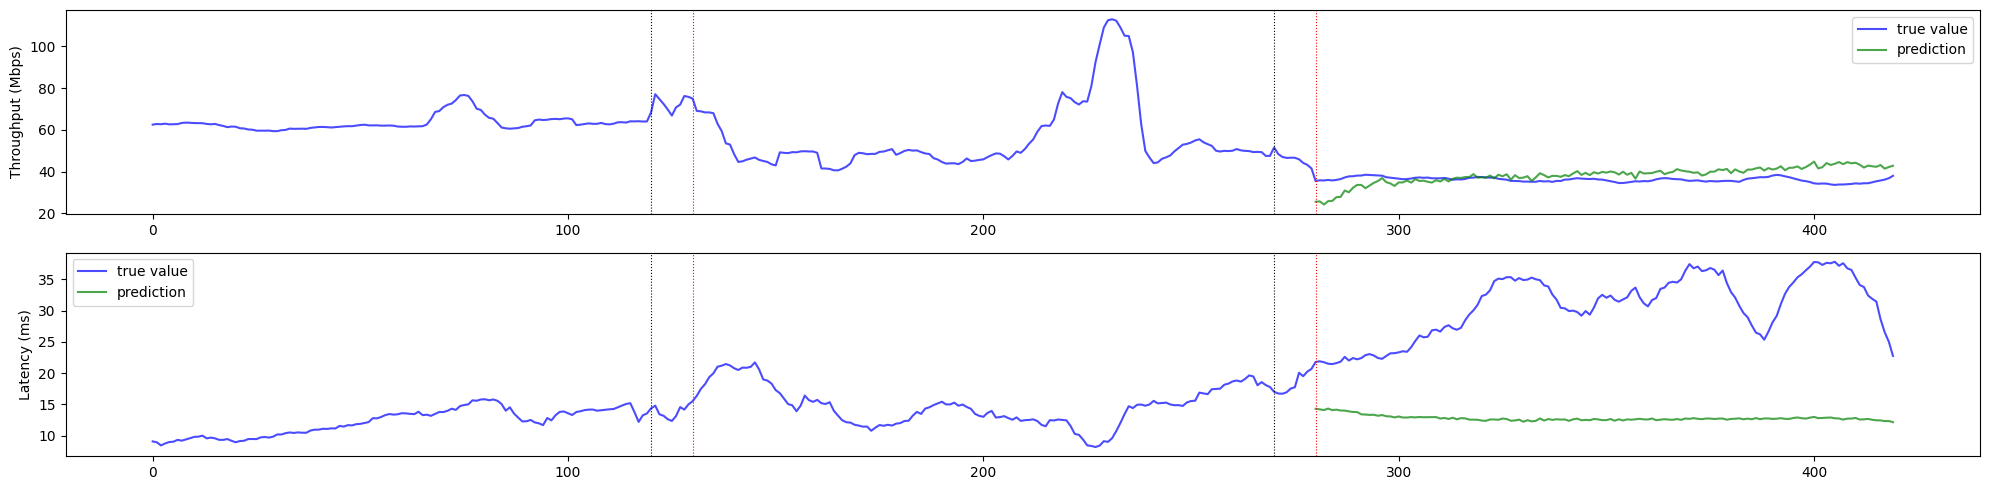

In [ ]:
ts_idx = 4
fig, ax = plt.subplots(2, figsize=(20,5))
ax[0].plot(torch.cat([x_batch[ts_idx,:,0], y_batch[ts_idx,:,0]]).detach().cpu(), alpha=0.7, c='blue', label='true value')
ax[0].plot(torch.arange(y_batch.shape[1]) + x_batch.shape[1], outputs.prediction_outputs[ts_idx,:,0].detach().cpu(), alpha=0.7, c='green', label="prediction")
ax[0].axvline(x_batch.shape[1], lw=0.8, ls=":", c='red')
ax[0].axvline(x_batch.shape[1]-150, lw=0.8, ls=":", c='red')
ax[0].axvline(x_batch.shape[1]-10, lw=0.8, ls=":", c='black')
ax[0].axvline(x_batch.shape[1]-160, lw=0.8, ls=":", c='black')
ax[0].set_ylabel('Throughput (Mbps)')
ax[0].legend()
# ax[0].grid(True)

ax[1].plot(torch.cat([x_batch[ts_idx,:,1], y_batch[ts_idx,:,1]]).detach().cpu(), alpha=0.7, c='blue', label='true value')
ax[1].plot(torch.arange(y_batch.shape[1]) + x_batch.shape[1], outputs.prediction_outputs[ts_idx,:,1].detach().cpu(), alpha=0.7, c='green', label="prediction")
ax[1].axvline(x_batch.shape[1], lw=0.8, ls=":", c='red')
ax[1].axvline(x_batch.shape[1]-150, lw=0.8, ls=":", c='red')
ax[1].axvline(x_batch.shape[1]-10, lw=0.8, ls=":", c='black')
ax[1].axvline(x_batch.shape[1]-160, lw=0.8, ls=":", c='black')
ax[1].set_ylabel('Latency (ms)')
ax[1].legend()
# ax[1].grid(True)

plt.tight_layout()
plt.show()